<a href="https://colab.research.google.com/github/deepak-ucfknight/Machine_Learning_Spring19/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 3**

## **Problem 1 : Feature Extraction using Data Augmentation **

## **Downloading the Cats and Dogs Data**

In [1]:
#cats and dogs image from google
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 22:02:26--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   119MB/s    in 0.5s    

2019-04-18 22:02:27 (119 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## **Downloading VGG 19 with imagenet weights**

In [4]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 7s 0us/step


In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## **Extracting features from the last layer in Conv_base of VGG19**

In [6]:
conv_base.trainable = False
for layer in conv_base.layers:
  layer.trainable = False
  
last_layer = conv_base.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


## **Concatenating a Dense Network on Top of VGG 19**

In [0]:
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras import Model


x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = models.Model(conv_base.input, x)





## **Freezing VGG19 layer and extracting features for Cats and Dogs Dataset from pre-trained weights**

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    shuffle=True,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
100/100 [==============================] - 41s 408ms/step - loss: 0.5994 - acc: 0.6765 - val_loss: 0.4786 - val_acc: 0.7520
Epoch 2/10
100/100 [==============================] - 32s 323ms/step - loss: 0.4701 - acc: 0.7805 - val_loss: 0.3346 - val_acc: 0.8610
Epoch 3/10
100/100 [==============================] - 33s 325ms/step - loss: 0.4236 - acc: 0.8100 - val_loss: 0.3187 - val_acc: 0.8680
Epoch 4/10
100/100 [==============================] - 33s 326ms/step - loss: 0.3951 - acc: 0.8205 - val_loss: 0.2606 - val_acc: 0.8940
Epoch 5/10
100/100 [==============================] - 32s 323ms/step - loss: 0.3636 - acc: 0.8345 - val_loss: 0.2481 - val_acc: 0.8940
Epoch 6/10
100/100 [==============================] - 33s 335ms/step - loss: 0.3493 - acc: 0.8435 - val_loss: 0.2606 - val_acc: 0.8920
Epoch 7/10
100/100 [==============================] - 32s 

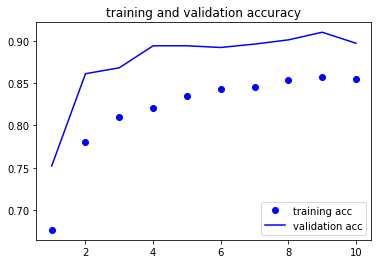

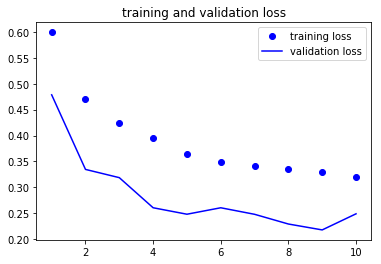

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## **Problem 2: Fine Tuning VGG19  by re-training the last CONV block in VGG19**

In [11]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
    


model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])


model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    shuffle=True,
    validation_data=validation_generator,
    validation_steps=50
)


Epoch 1/10
100/100 [==============================] - 36s 363ms/step - loss: 0.2975 - acc: 0.8700 - val_loss: 0.1789 - val_acc: 0.9350
Epoch 2/10
100/100 [==============================] - 34s 345ms/step - loss: 0.2403 - acc: 0.8980 - val_loss: 0.1296 - val_acc: 0.9480
Epoch 3/10
100/100 [==============================] - 33s 334ms/step - loss: 0.1971 - acc: 0.9205 - val_loss: 0.1414 - val_acc: 0.9450
Epoch 4/10
100/100 [==============================] - 33s 335ms/step - loss: 0.1836 - acc: 0.9250 - val_loss: 0.1113 - val_acc: 0.9600
Epoch 5/10
100/100 [==============================] - 34s 336ms/step - loss: 0.1671 - acc: 0.9325 - val_loss: 0.1263 - val_acc: 0.9550
Epoch 6/10
100/100 [==============================] - 35s 346ms/step - loss: 0.1579 - acc: 0.9365 - val_loss: 0.1493 - val_acc: 0.9490
Epoch 7/10
100/100 [==============================] - 35s 346ms/step - loss: 0.1291 - acc: 0.9495 - val_loss: 0.1091 - val_acc: 0.9570
Epoch 8/10
100/100 [==============================] - 3

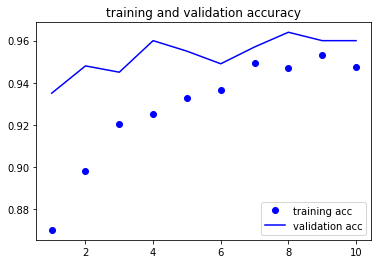

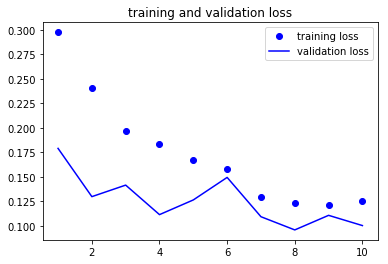

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

## **Problem 3: Visualizing Heat Maps in Model 2**

In [0]:
last_conv_layer = model.get_layer("block5_conv4")

In [0]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import utils

In [0]:
def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  # resize the heatmap to be the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.4 + img

  cv2_imshow(superimposed_img)

In [0]:
vgg19 = VGG19(weights='imagenet') 
layer = vgg19.get_layer("block5_conv4")

def process_image(img_path, idx=0):
  img = image.load_img(img_path, target_size=(224, 224))
  
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
 
  preds = vgg19.predict(x)
  
  print('Predicted:', decode_predictions(preds, top=3)[0])
  
  #class_index = np.argmax(preds[0])
 
  class_index = np.argsort(preds[0])[-(1+idx)]
  
  class_output = vgg19.output[:, class_index]
  
  grads = K.gradients(class_output, layer.output)[0]

  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  iterate = K.function([vgg19.input], [pooled_grads, layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  #
  show_superimposed_image(img_path, heatmap)

In [19]:
!ls /tmp/cats_and_dogs_filtered/validation/cats | head -3
!ls /tmp/cats_and_dogs_filtered/validation/dogs | head -3

cat.2000.jpg
cat.2001.jpg
cat.2002.jpg
dog.2000.jpg
dog.2001.jpg
dog.2002.jpg


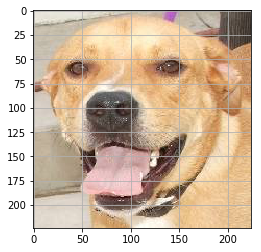

Predicted: [('n02099712', 'Labrador_retriever', 0.78212374), ('n02093256', 'Staffordshire_bullterrier', 0.031682175), ('n02093428', 'American_Staffordshire_terrier', 0.027616164)]


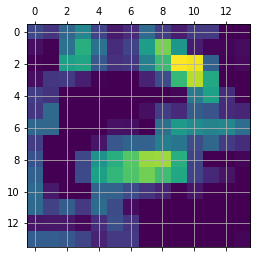

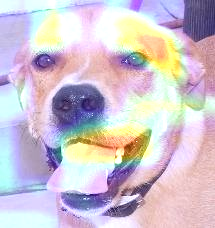

In [32]:
process_image('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg')

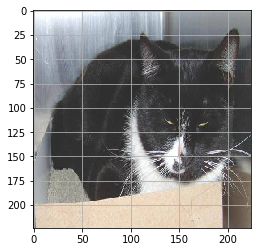

Predicted: [('n02124075', 'Egyptian_cat', 0.17199294), ('n02971356', 'carton', 0.12826574), ('n03207941', 'dishwasher', 0.06350011)]


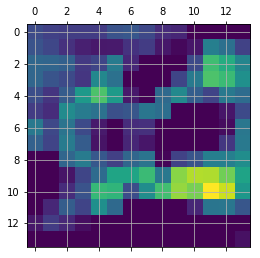

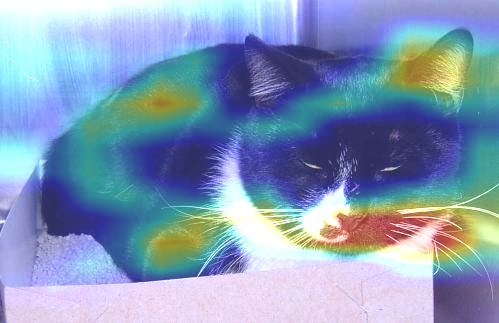

In [33]:
process_image('/tmp/cats_and_dogs_filtered/validation/cats/cat.2001.jpg')

## **Problem 4:  Visualizing Intermediate Activations from the ConvNet layers**

In [34]:
!ls /tmp/cats_and_dogs_filtered/validation/cats | head -3
!ls /tmp/cats_and_dogs_filtered/validation/dogs | head -3

cat.2000.jpg
cat.2001.jpg
cat.2002.jpg
dog.2000.jpg
dog.2001.jpg
dog.2002.jpg


## **We have chosen First Dog Image from the Validation Set for Visualization Purpose**, 
**we can select any Image doesn't matter**

In [0]:

def Create_image_tensor(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  return img_tensor

## **Create a Tensor of the Image**

In [0]:
img_path = '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg'
dog_2001_tensor = Create_image_tensor(img_path)

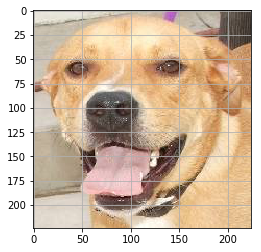

In [37]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(dog_2001_tensor[0])
plt.grid(None)
plt.show()

In [38]:
model.predict(dog_2001_tensor)

array([[1.]], dtype=float32)

## **Build Activation Model to get intermediate Activations**

In [39]:
from keras import models


layer_outputs = [layer.output for layer in model.layers[1:25]]
activation_model = models.Model(outputs=layer_outputs,input=model.input)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  """


In [0]:
activations = activation_model.predict(dog_2001_tensor)

## **Function to Visualize Each Layer of the ConvNet, just pass the layer Index to it**

In [0]:
def visualize_ConvNETs(layerIndex):
  
  layer_name = model.layers[layerIndex].name
  
  images_per_row = 16

  layer_activation = activations[layerIndex-1]
  # the feature map has shape (1, size, size, n_features)
  n_features = activations[layerIndex-1].shape[-1] 
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]

      channel_image -= channel_image.mean()
      if(channel_image.std() != 0):
        channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[
          col * size : (col + 1) * size,
          row * size : (row + 1) * size] = channel_image


  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')




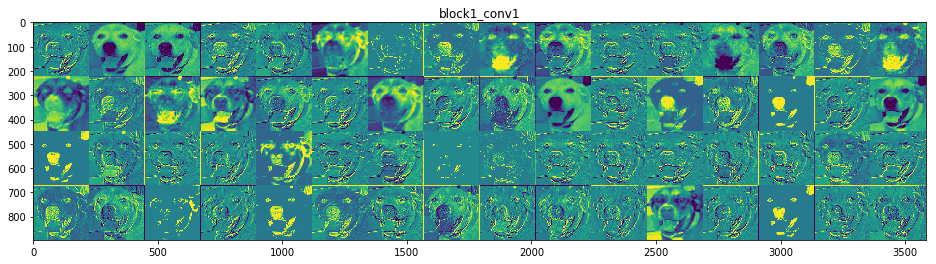

In [0]:
visualize_ConvNETs(1)

## **Visualizing last ConvNet Activation in the Architecture**

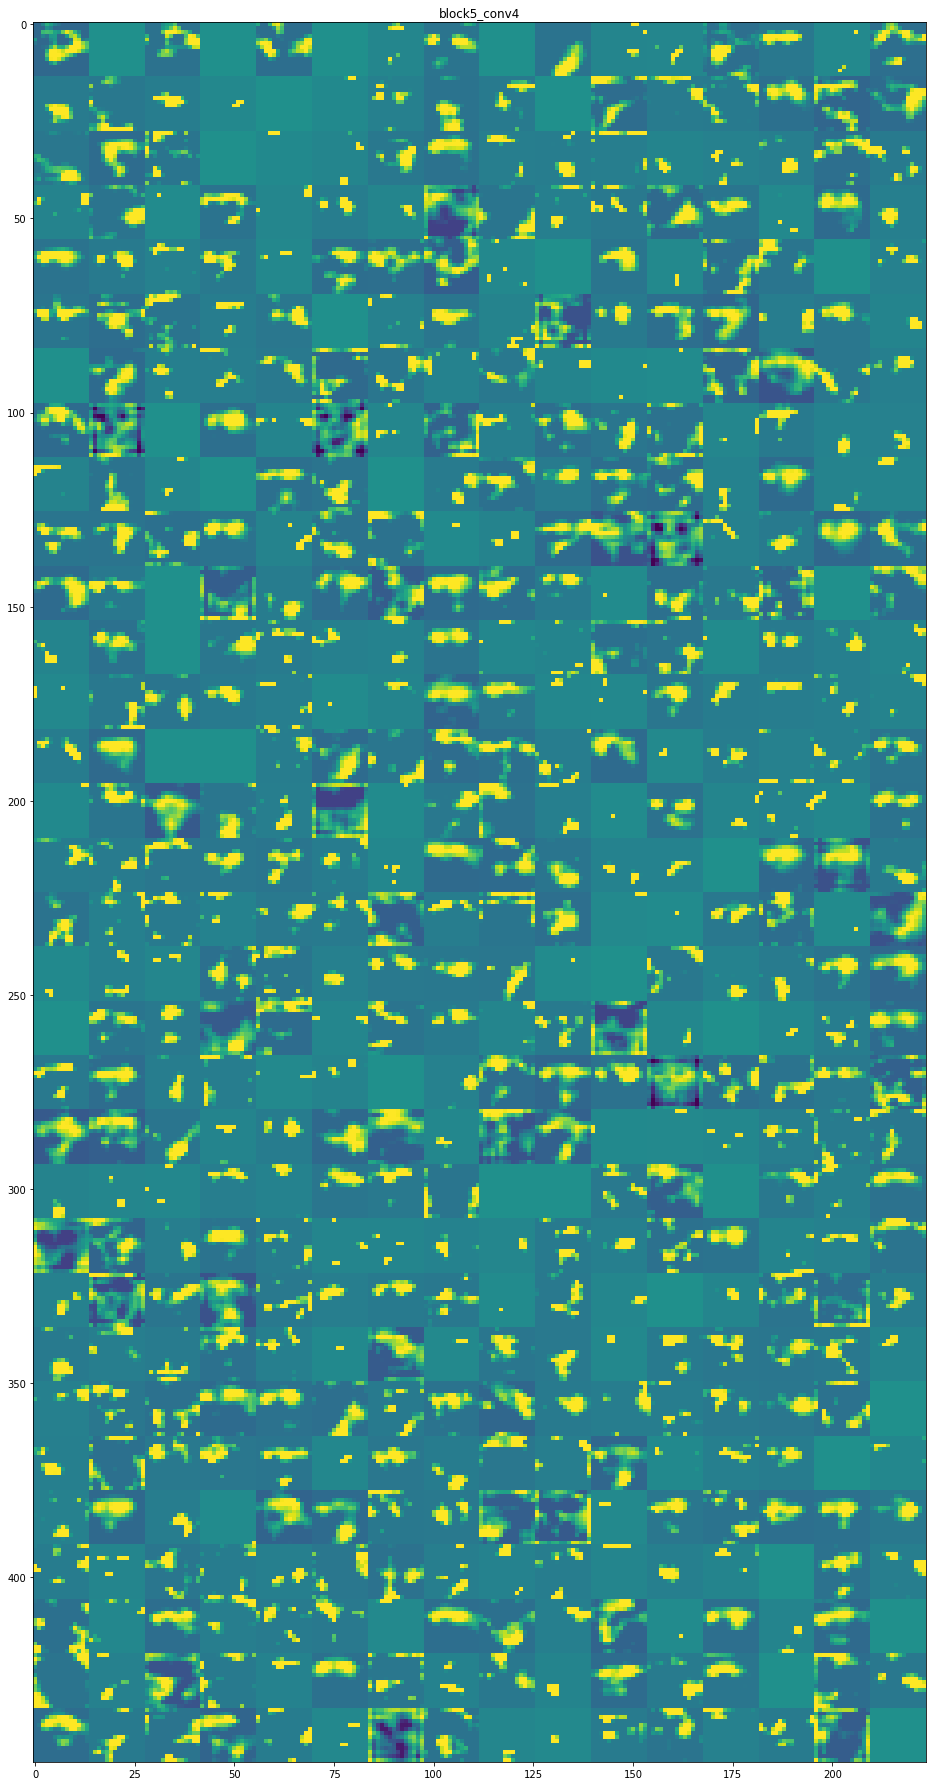

In [42]:
visualize_ConvNETs(20)

## **T-SNE VISUALIZATION**


In [0]:
from keras.preprocessing import image
import numpy as np

validation_images = []
labels = []

val_cat_fnames = os.listdir(validation_cats_dir)
val_dog_fnames = os.listdir(validation_dogs_dir)


cat_val = [os.path.join(validation_cats_dir, fname) 
                for fname in val_cat_fnames[0:]]
dog_val = [os.path.join(validation_dogs_dir, fname) 
                for fname in val_dog_fnames[0:]]

for i, img_path in enumerate(cat_val+dog_val):
  
  true_label = (img_path)[39:42]
  dog_val.append(true_label)
  
  pred_img = image.load_img(img_path, target_size=(224,224))
  img_tensor = image.img_to_array(pred_img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  validation_images.append(img_tensor)
  

In [44]:
layer = model.get_layer('dense_1')
layer_output = layer.output
img_tensors_array = np.concatenate((validation_images))
activation_model = models.Model(input=model.input, outputs=[layer_output])
activations = activation_model.predict(img_tensors_array)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  after removing the cwd from sys.path.


In [0]:
class_names = ["cat", "dog"]

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

In [47]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

cats_and_dogs_tsne = TSNE(random_state=10).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 6.319416284561157 seconds


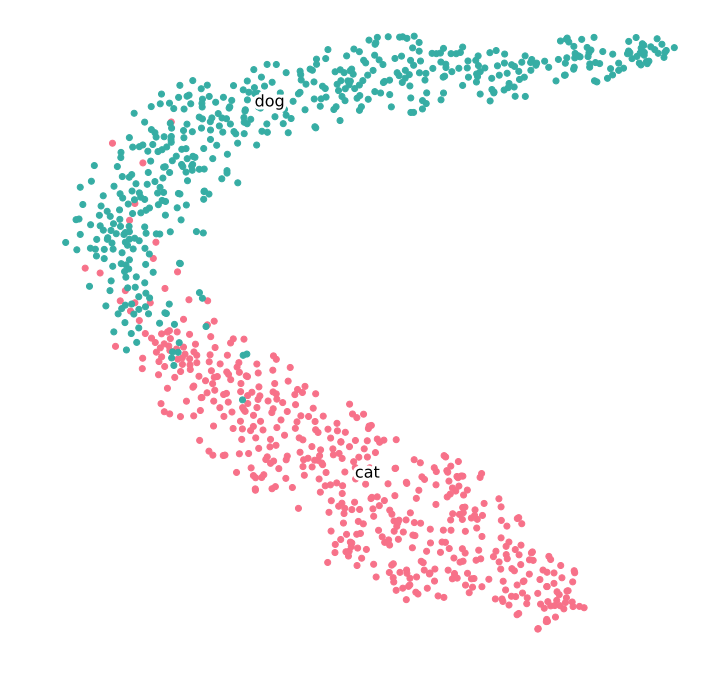

In [48]:
# visualize t-SNE output

data_scatter(cats_and_dogs_tsne, validation_generator.classes)